In [1]:
# Imports
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import KFold
from sklearn.linear_model import LassoCV
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import r2_score
from bayes_opt import BayesianOptimization
import scipy.interpolate
import time
import xgboost as xgb

# Definitions
pd.set_option('display.float_format', lambda x: '%.4f' % x)
%matplotlib inline
warnings.simplefilter('ignore')
N_JOBS = -1
FOLDS = 3
SEED = 2017

C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Fit, predict and return error
def run_et(max_features, max_depth, min_samples_split, min_samples_leaf) :
    # Define train and test sets for BO process
    oof_preds = pd.DataFrame()
    oof_targets = pd.DataFrame()
    kf = KFold(n_splits = FOLDS, shuffle = True, random_state = SEED)
    for i, (train_index, test_index) in enumerate(kf.split(train)):
        X_train, X_val = train.iloc[train_index], train.iloc[test_index]
        y_train, y_val = y.iloc[train_index], y.iloc[test_index]
       
        # Fit model
        et = ExtraTreesRegressor(n_estimators = 100, 
                                 max_features = max_features, 
                                 max_depth = int(max_depth), 
                                 min_samples_split = int(min_samples_split), 
                                 min_samples_leaf = int(min_samples_leaf), 
                                 n_jobs = -1, 
                                 random_state = SEED)
        et.fit(X_train, y_train)

        # Compute score on this fold
        preds_val = et.predict(X_val)    
        
        # Store OOF predictions
        oof_preds = pd.concat([pd.Series(oof_preds), pd.Series(preds_val)], axis = 0)
        oof_targets = pd.concat([pd.Series(oof_targets), pd.Series(y_val.y)], axis = 0)
    
    # Compte error on OOF predictions
    cv_score = r2_score(oof_targets, oof_preds)

    return(cv_score)


def xgb_r2_score(preds, dtrain):
    labels = dtrain.get_label()
    return("r2", r2_score(labels, preds))

def run_xgb(max_depth, min_child_weight, subsample, colsample_bytree, colsample_bylevel) :

    xg_params = {"nthread" : N_JOBS, 
                 "eta" : 0.3, 
                 "max_depth" : int(max_depth), 
                 "min_child_weight" : int(min_child_weight), 
                 "subsample" : subsample, 
                 "colsample_bytree" : colsample_bytree, 
                 "colsample_bylevel" : colsample_bylevel, 
                 "base_score" : 0,
                 "objective" : "reg:linear"}    
    
    # Define train and test sets for BO process
    oof_preds = pd.DataFrame()
    oof_targets = pd.DataFrame()
    kf = KFold(n_splits = FOLDS, shuffle = True, random_state = SEED)
    for i, (train_index, test_index) in enumerate(kf.split(train)):
        X_train, X_val = train.iloc[train_index], train.iloc[test_index]
        y_train, y_val = y.iloc[train_index], y.iloc[test_index]

        # XGBoost needs another level of validation set
        X_testVal = X_train.sample(frac = (1 / FOLDS), random_state = (SEED * i))
        X_trainVal = X_train.drop(X_testVal.index, axis = 0)
        X_testVal_y = y_train.sample(frac = (1 / FOLDS), random_state = (SEED * i))
        X_trainVal_y = y_train.drop(X_testVal_y.index, axis = 0)

        # Find best iteration
        xg_trainVal = xgb.DMatrix(X_trainVal, label = X_trainVal_y)
        xg_testVal = xgb.DMatrix(X_testVal, label = X_testVal_y)   
        watchlist = [(xg_trainVal, "train"), (xg_testVal, "eval")]        
        xg = xgb.train(
            params = xg_params,
            dtrain = xg_trainVal,
            evals = watchlist, 
            num_boost_round = 100000,
            early_stopping_rounds = 100,
            feval = xgb_r2_score, 
            maximize = True,
            verbose_eval = False)

        # Now fit on whole train set with best iteration
        xg_train = xgb.DMatrix(X_train, label = y_train)
        xg = xgb.train(
            params = xg_params, 
            dtrain = xg_train, 
            num_boost_round = int(xg.best_ntree_limit * (1 + (1 / FOLDS))),
            feval = xgb_r2_score, 
            maximize = True,
            verbose_eval = False)

        # Compute score on this fold
        xg_val = xgb.DMatrix(X_val)
        preds_val = xg.predict(xg_val)    
        
        # Store OOF predictions
        oof_preds = pd.concat([pd.Series(oof_preds), pd.Series(preds_val)], axis = 0)
        oof_targets = pd.concat([pd.Series(oof_targets), pd.Series(y_val.y)], axis = 0)
    
    # Compte error on OOF predictions
    cv_score = r2_score(oof_targets, oof_preds)

    return(cv_score)

In [3]:
# Init Bayesian Optimization
et_max_features_min = 0.5
et_max_features_max = 1.0
et_max_depth_min = 3
et_max_depth_max = 7
et_min_samples_split_min = 2
et_min_samples_split_max = 10
et_min_samples_leaf_min = 2
et_min_samples_leaf_max = 10

xgb_max_depth_min = 3
xgb_max_depth_max = 4
xgb_min_child_weight_min = 2
xgb_min_child_weight_max = 10
xgb_subsample_min = 0.8
xgb_subsample_max = 1.0
xgb_colsample_bytree_min = 0.4
xgb_colsample_bytree_max = 1.0
xgb_colsample_bylevel_min = 0.4
xgb_colsample_bylevel_max = 1.0


def initBO() :
    if (MODEL == "et") :
        # Define the features to explore
        bo = BayesianOptimization(run_et, {
            "max_features" : (et_max_features_min, et_max_features_max), 
            "max_depth" : (et_max_depth_min, et_max_depth_max),
            "min_samples_split" : (et_min_samples_split_min, et_min_samples_split_max),
            "min_samples_leaf" : (et_min_samples_leaf_min, et_min_samples_leaf_max),
        })
        
        # Define the initial exploration : 10 points approximately covering the range of each parameter
        bo.explore({
            "max_features" : [0.8, 0.9, 0.5, 0.6, 0.8, 1.0, 0.7, 0.5, 0.6, 0.9],
            "max_depth" : [3, 6, 5, 7, 4, 6, 4, 6, 5, 3], 
            "min_samples_split" : [5, 2, 10, 3, 6, 8, 4, 9, 3, 6],
            "min_samples_leaf" : [4, 10, 4, 8, 2, 5, 6, 3, 7, 9]
        })
    elif (MODEL == "xg") :
        # Define the features to explore
        bo = BayesianOptimization(run_xgb, {
            "max_depth" : (xgb_max_depth_min, xgb_max_depth_max), 
            "min_child_weight" : (xgb_min_child_weight_min, xgb_min_child_weight_max),
            "subsample" : (xgb_subsample_min, xgb_subsample_max),
            "colsample_bytree" : (xgb_colsample_bytree_min, xgb_colsample_bytree_max),
            "colsample_bylevel" : (xgb_colsample_bylevel_min, xgb_colsample_bylevel_max), 
        })
        
        # Define the initial exploration : 10 points approximately covering the range of each parameter
        bo.explore({
            "max_depth" : [4, 3, 4, 3, 4, 3, 4, 3, 4, 3],
            "min_child_weight" : [2, 10, 7, 5, 4, 7, 8, 6, 3, 9],
            "subsample" : [0.85, 0.9, 0.8, 0.95, 0.95, 1.0, 0.8, 0.9, 0.85, 0.8],
            "colsample_bytree" : [0.4, 0.7, 1.0, 0.6, 0.9, 0.5, 0.8, 0.6, 0.8, 0.9], 
            "colsample_bylevel" :  [0.8, 0.6, 0.7, 1.0, 0.6, 0.9, 1.0, 0.5, 0.7, 0.4],
            })
    
    return(bo)

In [4]:
# Plot results of optimization
def graphBO(history_df, param1, param2, param1min, param1max, param2min, param2max, ratio) :
    x, y, z = history_df[param1].values, history_df[param2].values, history_df["RMSE"].values

    # Set up a regular grid of interpolation points
    xi, yi = np.linspace(param1min, param1max, 100), np.linspace(param2min, param2max, 100)
    xi, yi = np.meshgrid(xi, yi)

    # Interpolate
    rbf = scipy.interpolate.Rbf(x, y, z, function = "multiquadric", smooth = 0.5)
    zi = rbf(xi, yi)

    plt.figure()
    plt.imshow(zi, 
               cmap = "plasma", 
               aspect = ratio,
               vmin = z.min(), 
               vmax = z.max(), 
               origin = "lower",
               extent = [param1min, param1max, param2min, param2max])
    q = plt.scatter(x, y, c = z, cmap = "plasma")
    plt.colorbar(q)
    plt.xlabel(param1)
    plt.ylabel(param2)
    #plt.savefig("figures/XGB_" + param1 + "_" + param2 + ".png")
    plt.show(block = False)

<b>Script</b>

In [5]:
# Get data
train = pd.read_csv("clean_data/train.csv")
y = pd.read_csv("clean_data/y.csv")

display(train.shape)
display(train.head(2))
display(y.shape)
display(y.head(2))


(4209, 367)

,ID,X0,X1,X2,X3,X4,X5,X6,X8,X10,...,srp_3,srp_4,srp_5,srp_6,srp_7,srp_8,srp_9,srp_10,srp_11,srp_12
0,0,37,23,20,0,3,27,9,14,0,...,126.9740,-13.6255,1.2387,17.3415,96.0070,-3.7160,-2.4774,0.0000,30.9670,1.2387
1,5761,41,13,5,5,3,22,9,14,0,...,119.6126,-13.6255,0.0000,17.3415,93.6003,-2.4774,2.4774,0.0000,16.1028,1.2387


(4209, 1)

,y
0,130.8100
1,115.0700


In [6]:
# Run optimization
MODEL = "xg"
start = time.time()
bo = initBO()
bo.maximize(init_points = 10, n_iter = 140, xi = 0.05)
print("BayesianOptimization took %.2f seconds" % ((time.time() - start)))

Initialization
-------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bylevel |   colsample_bytree |   max_depth |   min_child_weight |   subsample | 
    1 | 00m03s |    0.54576 |              0.8000 |             0.4000 |      4.0000 |             2.0000 |      0.8500 | 
    2 | 00m03s |    0.56290 |              0.6000 |             0.7000 |      3.0000 |            10.0000 |      0.9000 | 
    3 | 00m06s |    0.55237 |              0.7000 |             1.0000 |      4.0000 |             7.0000 |      0.8000 | 
    4 | 00m04s |    0.56014 |              1.0000 |             0.6000 |      3.0000 |             5.0000 |      0.9500 | 
    5 | 00m05s |    0.55492 |              0.6000 |             0.9000 |      4.0000 |             4.0000 |      0.9500 | 
    6 | 00m03s |    0.56226 |              0.9000 |             0.5000 |      3.0000 |             7.0000 |      1.0000 | 
  

KeyboardInterrupt: 

In [7]:
# Store and look at results
history_df = pd.DataFrame(bo.res["all"]["params"])
history_df2 = pd.DataFrame(bo.res["all"]["values"])
history_df = pd.concat((history_df, history_df2), axis = 1)
history_df.rename(columns = { 0 : "RMSE"}, inplace = True)
history_df.index.names = ["Iteration"]
history_df.sort_values(["RMSE"], ascending = False, inplace = True)
#history_df.to_csv("../../data/temp_results/bo.csv")
display(history_df.head(10))

,colsample_bylevel,colsample_bytree,max_depth,min_child_weight,subsample,RMSE
Iteration,,,,,,
135,0.5601,0.8925,3.0112,7.5965,0.9937,0.5676
36,0.6089,0.4594,3.9984,8.6895,0.8665,0.5669
1,0.9826,0.7611,3.1845,3.0974,0.8311,0.5661
49,0.9790,0.8778,3.8696,2.3505,0.9095,0.5658
47,0.4830,0.9621,3.2987,3.0671,0.8984,0.5654
11,0.4294,0.6747,3.0421,3.6471,0.8637,0.5650
100,0.4096,0.9105,3.0039,8.4643,0.9965,0.5645
77,0.5895,0.9946,3.7402,4.5241,0.8827,0.5645
10,0.8921,0.9991,3.4206,5.8048,0.9142,0.5643


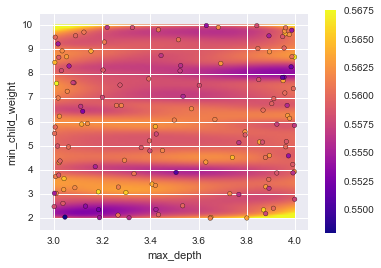

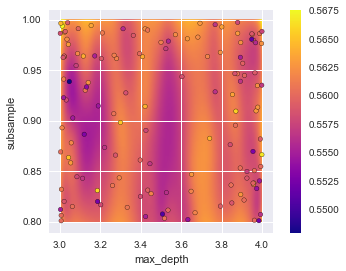

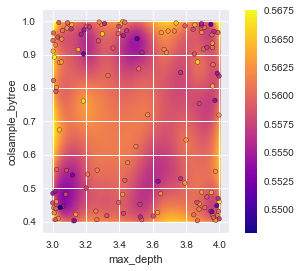

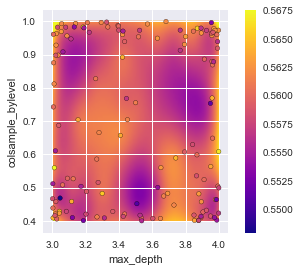

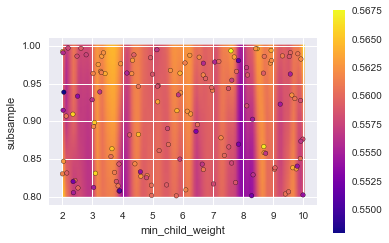

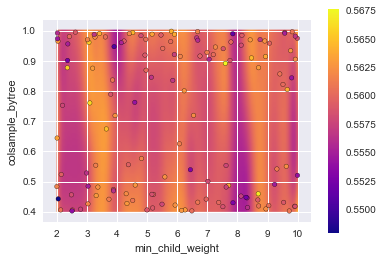

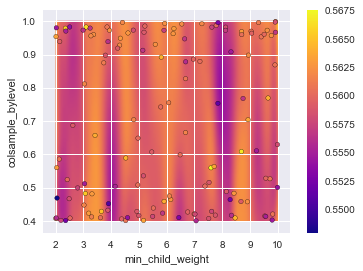

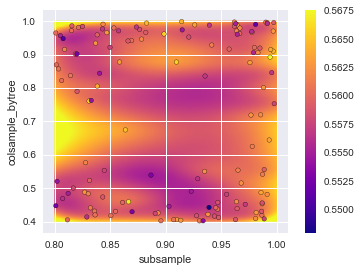

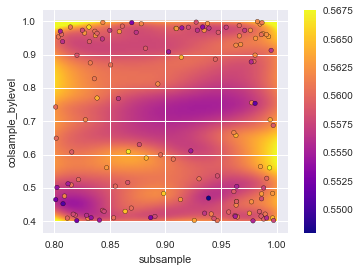

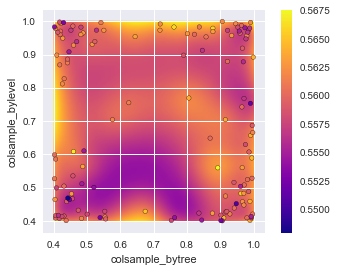

In [12]:
if (MODEL == "et") :
    graphBO(history_df, "max_features", "max_depth", et_max_features_min, et_max_features_max, et_max_depth_min, et_max_depth_max, 0.1)
    graphBO(history_df, "max_features", "min_samples_split", et_max_features_min, et_max_features_max, et_min_samples_split_min, et_min_samples_split_max, 0.06)
    graphBO(history_df, "max_features", "min_samples_leaf", et_max_features_min, et_max_features_max, et_min_samples_leaf_min, et_min_samples_leaf_max, 0.05)
    graphBO(history_df, "max_depth", "min_samples_split", et_max_depth_min, et_max_depth_max, et_min_samples_split_min, et_min_samples_split_max, 0.4)
    graphBO(history_df, "max_depth", "min_samples_leaf", et_max_depth_min, et_max_depth_max, et_min_samples_leaf_min, et_min_samples_leaf_max, 0.4)
    graphBO(history_df, "min_samples_split", "min_samples_leaf", et_min_samples_split_min, et_min_samples_split_max, et_min_samples_leaf_min, et_min_samples_leaf_max, 0.8)
elif (MODEL == "xg") :
    graphBO(history_df, "max_depth", "min_child_weight", xgb_max_depth_min, xgb_max_depth_max, xgb_min_child_weight_min, xgb_min_child_weight_max, 0.1)
    graphBO(history_df, "max_depth", "subsample", xgb_max_depth_min, xgb_max_depth_max, xgb_subsample_min, xgb_subsample_max, 5)
    graphBO(history_df, "max_depth", "colsample_bytree", xgb_max_depth_min, xgb_max_depth_max, xgb_colsample_bytree_min, xgb_colsample_bytree_max, 2)
    graphBO(history_df, "max_depth", "colsample_bylevel", xgb_max_depth_min, xgb_max_depth_max, xgb_colsample_bylevel_min, xgb_colsample_bylevel_max, 2)
    graphBO(history_df, "min_child_weight", "subsample", xgb_min_child_weight_min, xgb_min_child_weight_max, xgb_subsample_min, xgb_subsample_max, 25)
    graphBO(history_df, "min_child_weight", "colsample_bytree", xgb_min_child_weight_min, xgb_min_child_weight_max, xgb_colsample_bytree_min, xgb_colsample_bytree_max, 10)
    graphBO(history_df, "min_child_weight", "colsample_bylevel", xgb_min_child_weight_min, xgb_min_child_weight_max, xgb_colsample_bylevel_min, xgb_colsample_bylevel_max, 12)
    graphBO(history_df, "subsample", "colsample_bytree", xgb_subsample_min, xgb_subsample_max, xgb_colsample_bytree_min, xgb_colsample_bytree_max, 0.3)
    graphBO(history_df, "subsample", "colsample_bylevel", xgb_subsample_min, xgb_subsample_max, xgb_colsample_bylevel_min, xgb_colsample_bylevel_max, 0.3)
    graphBO(history_df, "colsample_bytree", "colsample_bylevel", xgb_colsample_bytree_min, xgb_colsample_bytree_max, xgb_colsample_bylevel_min, xgb_colsample_bylevel_max, 1)
else :
    graphBO(history_df, "max_depth", "num_leaves", max_depth_min, max_depth_max, num_leaves_min, num_leaves_max, 0.2)
    graphBO(history_df, "max_depth", "min_data_in_leaf", max_depth_min, max_depth_max, min_data_in_leaf_min, min_data_in_leaf_max, 0.2)
    graphBO(history_df, "max_depth", "feature_fraction", max_depth_min, max_depth_max, feature_fraction_min, feature_fraction_max, 8)
    graphBO(history_df, "max_depth", "bagging_fraction", max_depth_min, max_depth_max, bagging_fraction_min, bagging_fraction_max, 8)
    graphBO(history_df, "max_depth", "bagging_freq", max_depth_min, max_depth_max, bagging_freq_min, bagging_freq_max, 0.1)
    graphBO(history_df, "num_leaves", "min_data_in_leaf", num_leaves_min, num_leaves_max, min_data_in_leaf_min, min_data_in_leaf_max, 1)
    graphBO(history_df, "num_leaves", "feature_fraction", num_leaves_min, num_leaves_max, feature_fraction_min, feature_fraction_max, 25)
    graphBO(history_df, "num_leaves", "bagging_fraction", num_leaves_min, num_leaves_max, bagging_fraction_min, bagging_fraction_max, 25)
    graphBO(history_df, "num_leaves", "bagging_freq", num_leaves_min, num_leaves_max, bagging_freq_min, bagging_freq_max, 0.4)
    graphBO(history_df, "min_data_in_leaf", "feature_fraction", min_data_in_leaf_min, min_data_in_leaf_max, feature_fraction_min, feature_fraction_max, 25)
    graphBO(history_df, "min_data_in_leaf", "bagging_fraction", min_data_in_leaf_min, min_data_in_leaf_max, bagging_fraction_min, bagging_fraction_max, 25)
    graphBO(history_df, "min_data_in_leaf", "bagging_freq", min_data_in_leaf_min, min_data_in_leaf_max, bagging_freq_min, bagging_freq_max, 0.5)
    graphBO(history_df, "feature_fraction", "bagging_fraction", feature_fraction_min, feature_fraction_max, bagging_fraction_min, bagging_fraction_max, 1)
    graphBO(history_df, "feature_fraction", "bagging_freq", feature_fraction_min, feature_fraction_max, bagging_freq_min, bagging_freq_max, 0.01)
    graphBO(history_df, "bagging_fraction", "bagging_freq", bagging_fraction_min, bagging_fraction_max, bagging_freq_min, bagging_freq_max, 0.01)